In [83]:
import pandas as pd
import matplotlib.colors as mc # For the legend
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import yaml

from matplotlib.cm import ScalarMappable
from pypsa.descriptors import Dict


In [84]:
snakemake = Dict()

with open(f"../config.yaml",'r') as f:
    snakemake.config = yaml.safe_load(f)
    
snakemake.input = Dict()
snakemake.output = Dict()

### Prepare data

In [85]:
if True:
    folder="../results/report"
    scenario="10/2025/DE/p1"

    snakemake.input.data = f"{folder}/networks/{scenario}/ref.csv"
    snakemake.output.plot = f"{folder}/plots/plot.pdf"

    df = pd.read_csv(snakemake.input.data)
    

In [86]:
df

,snapshot,iteration 0,iteration 1,iteration 2
0,2013-01-01 00:00:00,0.0,0.966763,0.966763
1,2013-01-01 03:00:00,0.0,0.966636,0.966636
2,2013-01-01 06:00:00,0.0,0.993095,0.993095
3,2013-01-01 09:00:00,0.0,1.000000,1.000000
4,2013-01-01 12:00:00,0.0,0.993250,0.993250
...,...,...,...,...
2915,2013-12-31 09:00:00,0.0,0.992380,0.992380
2916,2013-12-31 12:00:00,0.0,0.991199,0.991199
2917,2013-12-31 15:00:00,0.0,0.797333,0.797333
2918,2013-12-31 18:00:00,0.0,0.909347,0.909347


In [87]:
df["snapshot"] = pd.to_datetime(df["snapshot"])

In [88]:
type(df["snapshot"][0])

pandas._libs.tslibs.timestamps.Timestamp

### Create heatmap 

In [89]:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap = "BrBG"

In [90]:
MIN = df["iteration 1"].min() #case of CFE -> 0
MAX = df["iteration 1"].max() #case of CFE -> 1

In [91]:
def heatmap(data, month, year, ax):
    data = df[(df["snapshot"].dt.month == month)]

    snapshot = data["snapshot"]
    day = data["snapshot"].dt.day
    value = data["iteration 1"]
    value = value.values.reshape(8, len(day.unique()), order="F") # 8 clusters of 3h in each day
    
    xgrid = np.arange(day.max() + 1) + 1  # The inner + 1 increases the length, the outer + 1 ensures days start at 1, and not at 0
    ygrid = np.arange(9) #8 and extra 1
    
    ax.pcolormesh(xgrid, ygrid, value, cmap=colormap, vmin=MIN, vmax=MAX)
    # Invert the vertical axis
    ax.set_ylim(8, 0)
    # Set tick positions for both axes
    ax.yaxis.set_ticks([i for i in range(8)])
    ax.xaxis.set_ticks([])
    # Remove ticks by setting their length to 0
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    
    # Remove all spines
    ax.set_frame_on(False)

Text(0.5, 0.98, 'Carbon Heat Map | ..')

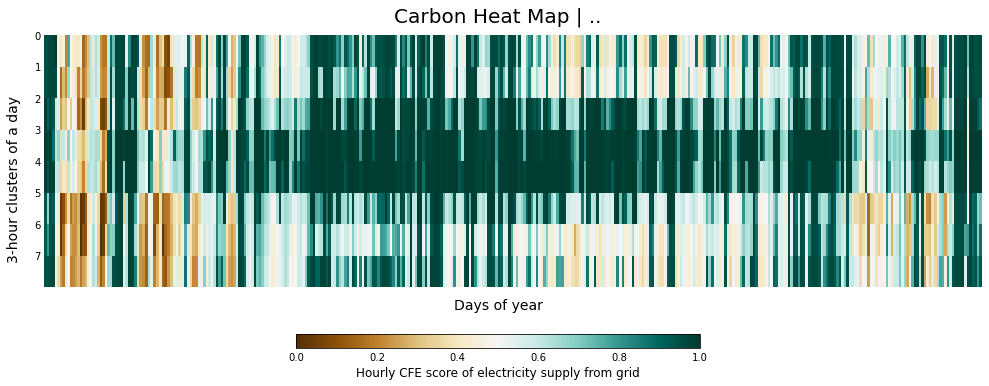

In [92]:
# Here 1 row year/variable and 12 columns for month

fig, axes = plt.subplots(1, 12, figsize=(14, 5), sharey=True)
plt.tight_layout()

for i, year in enumerate([2013]):
    for j, month in enumerate(range(1, 13)):
        #print(f'j: {j}, month: {month}')
        heatmap(df, month, year, axes[j])

# Adjust margin and space between subplots (extra space is on the left for a label)
fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.08, wspace=0) #wspace=0 stacks individual months together but easy to split

# some room for the legend in the bottom
fig.subplots_adjust(bottom=0.2)

# Create a new axis to contain the color bar
# Values are: (x coordinate of left border, y coordinate for bottom border, width, height)
cbar_ax = fig.add_axes([0.3, 0.03, 0.4, 0.04])

# Create a normalizer that goes from minimum to maximum temperature
norm = mc.Normalize(0, 1) #for CFE, otherwise (MIN, MAX)

# Create the colorbar and set it to horizontal
cb = fig.colorbar(
    ScalarMappable(norm=norm, cmap=colormap), 
    cax=cbar_ax, # Pass the new axis
    orientation = "horizontal")

# Remove tick marks and set label
cb.ax.xaxis.set_tick_params(size=0)
cb.set_label("Hourly CFE score of electricity supply from grid", size=12)

# add some figure labels and title
fig.text(0.5, 0.15, "Days of year", ha="center", va="center", fontsize=14)
fig.text(0.02, 0.5, '3-hour clusters of a day', ha="center", va="center", rotation="vertical", fontsize=14)
fig.suptitle(f"Carbon Heat Map | ..", fontsize=20, y=0.98)

In [93]:
# save the plot
#fig.set_facecolor("white")
fig.savefig("plot.pdf", bbox_inches = "tight", transparent=True)